 <font size="3"> Import Functions </font>

In [132]:
#!conda install -y -c conda-forge xgboost

In [131]:
#pip install geopy

#DF/EDA imports
import geopy.distance
import pandas as pd
import numpy as np

#plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
import matplotlib.cm as cm

#modeling imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

 <font size="3"> Importing/Cleaning Data and EDA </font>

In [4]:
df = pd.read_csv('cc_fraud.csv')

In [5]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [6]:
df['name'] = df['first'] + " " + df['last']

In [7]:
df = df.drop(columns = ["Unnamed: 0", "first" , "last" , "trans_num"])

In [8]:
len(df['name'].unique())

917

In [9]:
(df.is_fraud == 1).sum()

2145

In [10]:
percent_fraud = 2145 / 555719
print(percent_fraud)
print(1 - percent_fraud)

0.0038598644278853163
0.9961401355721147


 <font size="3"> Adding Features: "Purchase Distance" ,"Time Since Last Purchase", and "Cumulative Fraud" </font>

In [11]:
lat_list = list(df["lat"])
long_list = list(df["long"])
merch_lat_list = list(df["merch_lat"])
merch_long_list = list(df["merch_long"])

In [12]:
def distance_from_merch(lat1 , lat2 , long1 , long2):
    coords_1 = (lat1, long1)
    coords_2 = (lat2, long2)
    return geopy.distance.distance(coords_1, coords_2).miles

In [13]:
distance_list = []
for idx, x in enumerate(lat_list):
    distance_list.append(distance_from_merch(lat_list[idx], merch_lat_list[idx], long_list[idx], merch_long_list[idx]))
    

In [14]:
df["Purchase_Distance"] = distance_list

In [15]:
df = df.drop(columns = ["lat", "long" , "merch_lat" , "merch_long", 'cc_num' , 'street' , 'city' , 'state'])

In [16]:
df['time_since_prev_purchase'] = df.groupby('name')['unix_time'].diff()

In [20]:
df['cumulative_fraud'] = df.groupby('name')['is_fraud'].cumsum()

In [27]:
df = df.drop(columns = ["trans_date_trans_time", "unix_time" , 'job'])

 <font size="3"> Exploring Updated Data Frame </font>

In [36]:
fraud_df = df[df.is_fraud != 0]
#fraud_df

In [37]:
ana_df = df[df.name == "Ana Howell"]
#ana_df[ana_df.is_fraud == 1]

In [43]:
scamees = (df.loc[df['name'].isin(fraud_df.name.unique())])
scamees.describe()

,amt,zip,city_pop,is_fraud,Purchase_Distance,time_since_prev_purchase,cumulative_fraud
count,126490.000000,126490.000000,1.264900e+05,126490.000000,126490.000000,126272.000000,126490.000000
mean,74.524399,48510.330255,5.370348e+04,0.016958,47.164758,26660.370510,5.729425
std,175.069507,26904.959579,1.795592e+05,0.129114,18.089556,39916.741214,5.545040
min,1.000000,1257.000000,2.300000e+01,0.000000,0.091947,0.000000,0.000000
25%,9.440000,24433.000000,9.720000e+02,0.000000,34.311467,4817.000000,0.000000
50%,46.230000,48034.000000,2.644000e+03,0.000000,48.465389,13206.000000,6.000000
75%,83.080000,70774.000000,1.474200e+04,0.000000,61.047387,32282.000000,11.000000
max,21437.710000,99921.000000,1.577385e+06,1.000000,91.157956,813237.000000,19.000000


In [192]:
len(scamees['name'].unique())

218

In [44]:
df.describe()

,amt,zip,city_pop,is_fraud,Purchase_Distance,time_since_prev_purchase,cumulative_fraud
count,555719.000000,555719.000000,5.557190e+05,555719.000000,555719.000000,5.548020e+05,555719.000000
mean,69.392810,48842.628015,8.822189e+04,0.003860,47.288052,2.705924e+04,1.304103
std,156.745941,26855.283328,3.003909e+05,0.062008,18.077446,3.950424e+04,3.573462
min,1.000000,1257.000000,2.300000e+01,0.000000,0.077162,0.000000e+00,0.000000
25%,9.630000,26292.000000,7.410000e+02,0.000000,34.366305,5.001000e+03,0.000000
50%,47.290000,48174.000000,2.408000e+03,0.000000,48.596896,1.372100e+04,0.000000
75%,83.010000,72011.000000,1.968500e+04,0.000000,61.192229,3.320000e+04,0.000000
max,22768.110000,99921.000000,2.906700e+06,1.000000,93.624323,1.136944e+06,19.000000


In [45]:
fraud_df.describe()

,amt,zip,city_pop,is_fraud,Purchase_Distance,time_since_prev_purchase,cumulative_fraud
count,2145.000000,2145.000000,2.145000e+03,2145.0,2145.000000,2125.000000,2145.000000
mean,528.356494,47862.900233,6.452932e+04,1.0,47.357439,20265.462118,5.945921
std,392.747594,26706.283776,2.192075e+05,0.0,18.170757,32228.359172,3.569782
min,1.780000,1257.000000,2.300000e+01,1.0,2.391444,2.000000,1.000000
25%,214.510000,23937.000000,1.131000e+03,1.0,34.346876,1433.000000,3.000000
50%,371.940000,47987.000000,2.870000e+03,1.0,48.848000,4915.000000,6.000000
75%,907.770000,68031.000000,1.233500e+04,1.0,61.151859,26926.000000,8.000000
max,1320.920000,99921.000000,1.577385e+06,1.0,88.683159,340498.000000,19.000000


Things to note: no real difference with purchase-distance, amount is on average much higher for fraud, 
time since previous purchase tends to be much lower for fraud as well. 
Will explore these two features with cumulative fraud

 <font size="3"> Exploring a Pair Plot </font>

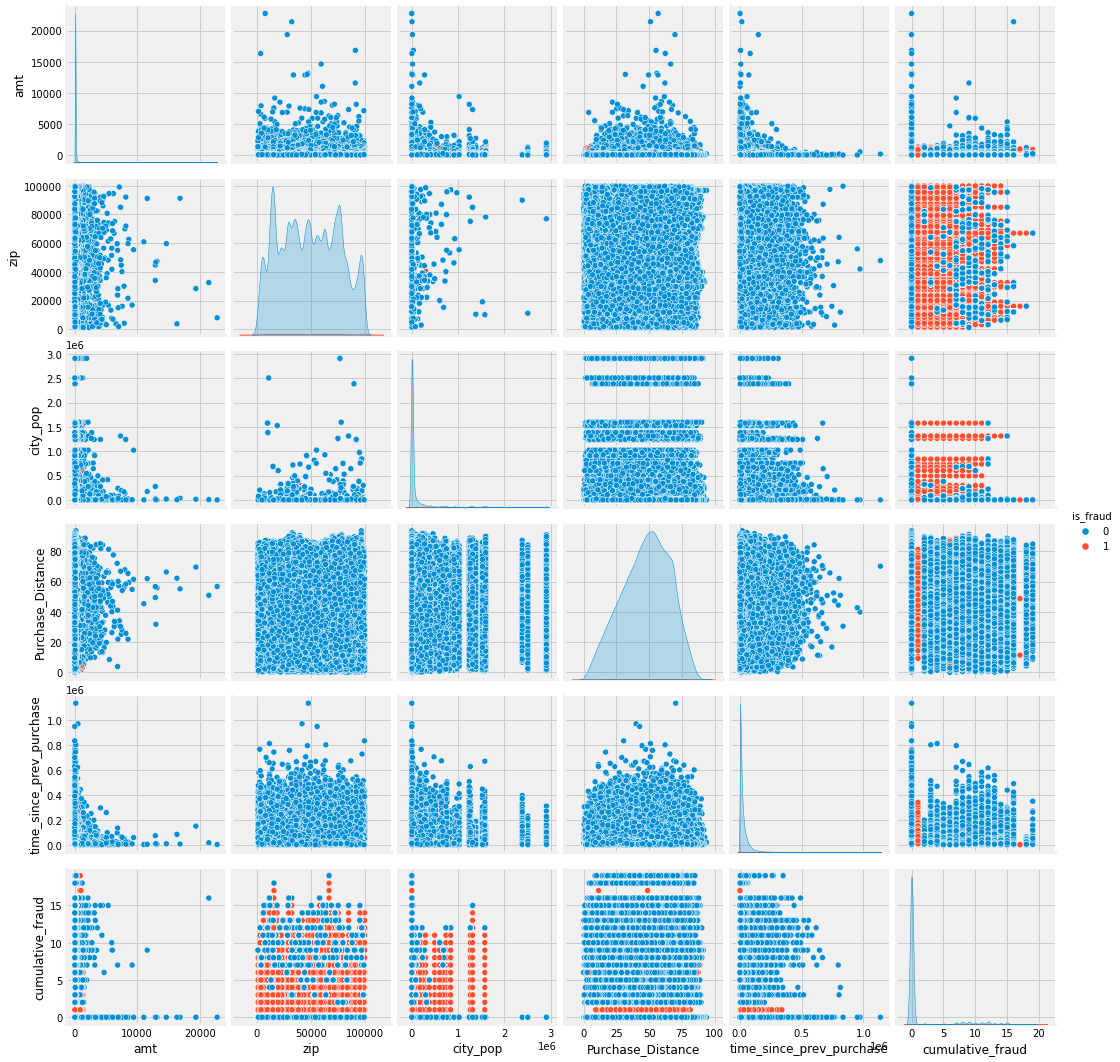

In [47]:
sns.pairplot(df, hue='is_fraud')

In [59]:
df = df.dropna()
df.head()

,merchant,amt,zip,city_pop,job,dob,is_fraud,name,Purchase_Distance,time_since_prev_purchase,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
52,fraud_Douglas-White,79.51,82514,1645,Freight forwarder,1976-02-26,0,Louis Fisher,24.351281,821.0,...,0,0,0,0,0,0,0,0,0,1
63,fraud_Crona and Sons,1.93,12575,2258,Building surveyor,1937-03-17,0,William Thompson,55.811615,903.0,...,0,0,1,0,0,0,0,0,0,1
67,fraud_Ziemann-Waters,181.87,77358,4993,"Scientist, biomedical",1948-11-30,0,Kathleen Martin,43.843598,596.0,...,1,0,0,0,0,0,0,0,0,0
83,fraud_Powlowski-Weimann,19.06,35229,493806,Musician,1980-07-12,0,Samuel Johnston,32.699217,734.0,...,0,0,0,0,0,0,0,0,0,1
91,fraud_Stiedemann Ltd,128.33,53061,5196,Child psychotherapist,1978-01-22,0,Matthew Lambert,63.377492,247.0,...,0,0,0,0,0,0,0,0,0,1


In [60]:
df = pd.get_dummies(df, columns = ["category" , "gender"] , drop_first = True)

 <font size="3"> KNN Modeling </font>

In [51]:
df.columns

Index(['merchant', 'amt', 'zip', 'city_pop', 'job', 'dob', 'is_fraud', 'name',
       'Purchase_Distance', 'time_since_prev_purchase', 'cumulative_fraud',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M'],
      dtype='object')

In [67]:
'''
knn_X = df[['amt', 'zip',
       'time_since_prev_purchase', 'cumulative_fraud',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel']]
'''
knn_X = df[['amt', 'time_since_prev_purchase', 'cumulative_fraud']]
knn_y = df['is_fraud']

In [68]:
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(knn_X, knn_y, test_size=0.2, random_state=42)

In [199]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(knn_X_train, knn_y_train)
knn_y_pred = knn.predict(knn_X_test)
print(metrics.accuracy_score(knn_y_test, knn_y_pred))

0.9964221663467344


In [81]:
knn = KNeighborsClassifier(n_neighbors=100)
acc_scores = cross_val_score(knn, knn_X_train, knn_y_train, cv=10, scoring='accuracy')
prec_scores = cross_val_score(knn, knn_X_train, knn_y_train, cv=10, scoring='precision')
rec_scores = cross_val_score(knn, knn_X_train, knn_y_train, cv=10, scoring='recall')

print("Accuracy: " , acc_scores, "\n", "Precision: ", prec_scores, "\n", "Recall: ", rec_scores)

Accuracy:  [0.99635012 0.99657534 0.99637257 0.9963951  0.99641763 0.99630497
 0.99635004 0.99644016 0.99641763 0.9966204 ] 
 Precision:  [0.61764706 0.74285714 0.63333333 0.65625    0.66666667 0.58333333
 0.6        0.67647059 0.62790698 0.77777778] 
 Recall:  [0.12352941 0.15384615 0.11242604 0.12352941 0.12941176 0.12352941
 0.14117647 0.13529412 0.15882353 0.16470588]


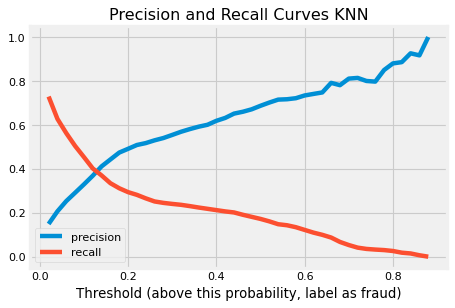

In [200]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(knn_y_train, knn.predict_proba(knn_X_train)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves KNN');

In [204]:
def knn_confusion_matrix(model, threshold=0.5):
    knn_y_predict = (model.predict_proba(knn_X_train)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(knn_y_train, knn_y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title('KNN Matrix');

In [205]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: knn_confusion_matrix(knn, threshold), threshold=(0,1.0000,0.0001))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

 <font size="3"> Logistic Modeling </font>

In [79]:
log_X = df[['amt', 'time_since_prev_purchase', 'cumulative_fraud']]
log_y = df['is_fraud']

In [80]:
log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(log_X, log_y, random_state=42)
lm = LogisticRegression(C = 10, max_iter=1000)
lm.fit(log_X_train, log_y_train)

LogisticRegression(C=10, max_iter=1000)

In [90]:
log_acc_scores = cross_val_score(lm, log_X_train, log_y_train, cv=10, scoring='accuracy')
log_prec_scores = cross_val_score(lm, log_X_train, log_y_train, cv=10, scoring='precision')
log_rec_scores = cross_val_score(lm, log_X_train, log_y_train, cv=10, scoring='recall')
print("Accuracy: " , log_acc_scores, "\n", "Precision: ", log_prec_scores, "\n", "Recall: ", log_rec_scores)

Accuracy:  [0.99586648 0.99601057 0.99598654 0.99584235 0.99567412 0.99584235
 0.99574621 0.99584235 0.99584235 0.99586638] 
 Precision:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 Recall:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


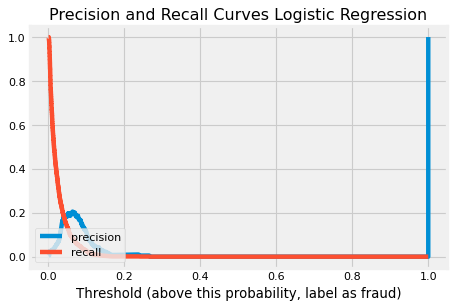

In [201]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(log_y_train, lm.predict_proba(log_X_train)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves Logistic Regression');

In [203]:
def log_confusion_matrix(model, threshold=0.5):
    log_y_predict = (model.predict_proba(log_X_train)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(log_y_train, log_y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title('Log Matrix');
    
interactive(lambda threshold: log_confusion_matrix(lm, threshold), threshold=(0,1.0000,0.0001))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

In [100]:
weighted_lm = LogisticRegression(class_weight={1 : 300, 0 : 1}, solver='liblinear')
weighted_lm.fit(log_X_train, log_y_train)


LogisticRegression(class_weight={0: 1, 1: 300}, solver='liblinear')

In [101]:
w_log_acc_scores = cross_val_score(weighted_lm, log_X_train, log_y_train, cv=10, scoring='accuracy')
w_log_prec_scores = cross_val_score(weighted_lm, log_X_train, log_y_train, cv=10, scoring='precision')
w_log_rec_scores = cross_val_score(weighted_lm, log_X_train, log_y_train, cv=10, scoring='recall')
print("Accuracy: " , w_log_acc_scores, "\n", "Precision: ", w_log_prec_scores, "\n", "Recall: ", w_log_rec_scores)

Accuracy:  [0.87498498 0.8763999  0.8741168  0.87159337 0.87267484 0.87351598
 0.87356405 0.87260274 0.87409277 0.87474165] 
 Precision:  [0.02737158 0.02605553 0.02559313 0.02457814 0.02513863 0.02388505
 0.02601747 0.02354032 0.02488307 0.0255447 ] 
 Recall:  [0.9125     0.86163522 0.86163522 0.8427673  0.85       0.8
 0.875      0.79375    0.83125    0.85      ]


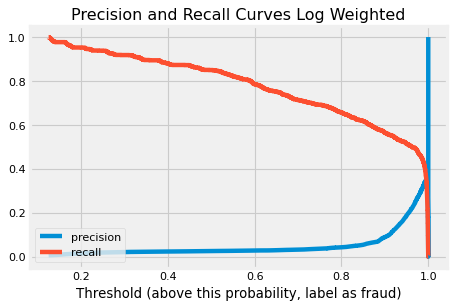

In [202]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(log_y_train, weighted_lm.predict_proba(log_X_train)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves Log Weighted');

In [206]:
interactive(lambda threshold: log_confusion_matrix(weighted_lm, threshold), threshold=(0,1.0000,0.0001))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

 <font size="3"> Decision Tree and Random Forest </font>

In [104]:
dt_X = df[['amt', 'time_since_prev_purchase', 'cumulative_fraud']]
dt_y = df['is_fraud']

In [105]:
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(dt_X, dt_y, random_state=42)
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(dt_X_train, dt_y_train)

DecisionTreeClassifier(max_depth=10)

In [106]:
dt_acc_scores = cross_val_score(dt, dt_X_train, dt_y_train, cv=10, scoring='accuracy')
dt_prec_scores = cross_val_score(dt, dt_X_train, dt_y_train, cv=10, scoring='precision')
dt_rec_scores = cross_val_score(dt, dt_X_train, dt_y_train, cv=10, scoring='recall')
print("Accuracy: " , dt_acc_scores, "\n", "Precision: ", dt_prec_scores, "\n", "Recall: ", dt_rec_scores)

Accuracy:  [0.99783711 0.99793319 0.99781303 0.99810142 0.99752463 0.99740447
 0.99812545 0.99769286 0.99776496 0.99814948] 
 Precision:  [0.74285714 0.80165289 0.74814815 0.8125     0.70676692 0.696
 0.81538462 0.7421875  0.76744186 0.8487395 ] 
 Recall:  [0.65       0.61006289 0.63522013 0.65408805 0.6        0.54375
 0.66875    0.5875     0.6375     0.63125   ]


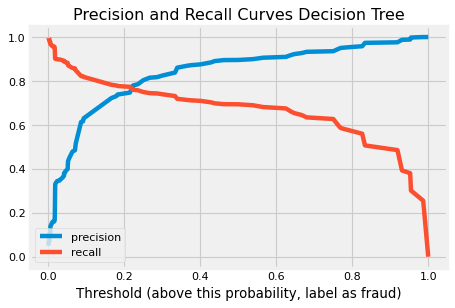

In [207]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(dt_y_train, dt.predict_proba(dt_X_train)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves Decision Tree');

In [108]:
def dt_confusion_matrix(model, threshold=0.5):
    dt_y_predict = (model.predict_proba(dt_X_train)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(dt_y_train, dt_y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [109]:
interactive(lambda threshold: dt_confusion_matrix(dt, threshold), threshold=(0,1.0000,0.0001))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

In [110]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(dt_X_train, dt_y_train)

RandomForestClassifier()

In [111]:
rf_acc_scores = cross_val_score(rf, dt_X_train, dt_y_train, cv=10, scoring='accuracy')
rf_prec_scores = cross_val_score(rf, dt_X_train, dt_y_train, cv=10, scoring='precision')
rf_rec_scores = cross_val_score(rf, dt_X_train, dt_y_train, cv=10, scoring='recall')
print("Accuracy: " , rf_acc_scores, "\n", "Precision: ", rf_prec_scores, "\n", "Recall: ", rf_rec_scores)

Accuracy:  [0.99822162 0.99814948 0.99807739 0.99831771 0.99781303 0.99762076
 0.99826965 0.99778899 0.99781303 0.99848594] 
 Precision:  [0.80141844 0.86111111 0.80620155 0.85950413 0.75590551 0.76521739
 0.86440678 0.79310345 0.79508197 0.90677966] 
 Recall:  [0.70625    0.57232704 0.63522013 0.66037736 0.6        0.5625
 0.625      0.5875     0.6        0.69375   ]


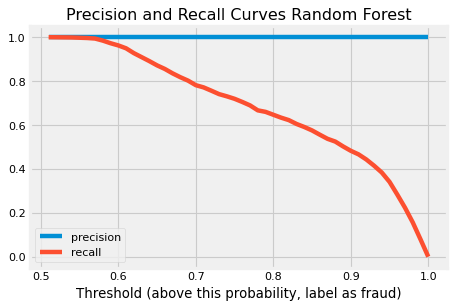

In [208]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(dt_y_train, rf.predict_proba(dt_X_train)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves Random Forest');

In [114]:
interactive(lambda threshold: dt_confusion_matrix(rf, threshold), threshold=(0,1.0000,0.0001))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

In [115]:
rf_acc_scores = cross_val_score(rf, dt_X_test, dt_y_test, cv=10, scoring='accuracy')
rf_prec_scores = cross_val_score(rf, dt_X_test, dt_y_test, cv=10, scoring='precision')
rf_rec_scores = cross_val_score(rf, dt_X_test, dt_y_test, cv=10, scoring='recall')
print("Accuracy: " , rf_acc_scores, "\n", "Precision: ", rf_prec_scores, "\n", "Recall: ", rf_rec_scores)

Accuracy:  [0.99769303 0.99776496 0.99798125 0.99776496 0.99834174 0.99812545
 0.99769286 0.99841384 0.99798125 0.99884643] 
 Precision:  [0.78378378 0.775      0.84375    0.80555556 0.82222222 0.78723404
 0.73333333 0.85714286 0.82857143 0.86666667] 
 Recall:  [0.58490566 0.57692308 0.55769231 0.54716981 0.69811321 0.67924528
 0.58490566 0.67924528 0.58490566 0.73584906]


In [125]:
def test_confusion_matrix(model, threshold=0.5):
    dt_y_predict = (model.predict_proba(dt_X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(dt_y_test, dt_y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    
interactive(lambda threshold: test_confusion_matrix(weighted_rf, threshold), threshold=(0,1.0000,0.0001))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

In [121]:
weighted_rf = RandomForestClassifier(n_estimators=100, class_weight={1 : 300, 0 : 1})
weighted_rf.fit(dt_X_train, dt_y_train)

RandomForestClassifier(class_weight={0: 1, 1: 300})

In [122]:
rf_acc_scores = cross_val_score(weighted_rf, dt_X_train, dt_y_train, cv=10, scoring='accuracy')
rf_prec_scores = cross_val_score(weighted_rf, dt_X_train, dt_y_train, cv=10, scoring='precision')
rf_rec_scores = cross_val_score(weighted_rf, dt_X_train, dt_y_train, cv=10, scoring='recall')
print("Accuracy: " , rf_acc_scores, "\n", "Precision: ", rf_prec_scores, "\n", "Recall: ", rf_rec_scores)

Accuracy:  [0.99814953 0.99790916 0.99824561 0.99831771 0.99774093 0.99762076
 0.99810142 0.99793319 0.99793319 0.99843788] 
 Precision:  [0.81481481 0.85858586 0.832      0.84251969 0.78512397 0.76724138
 0.84745763 0.77235772 0.80869565 0.90434783] 
 Recall:  [0.7        0.57232704 0.63522013 0.67295597 0.5875     0.55
 0.625      0.5875     0.58125    0.64375   ]


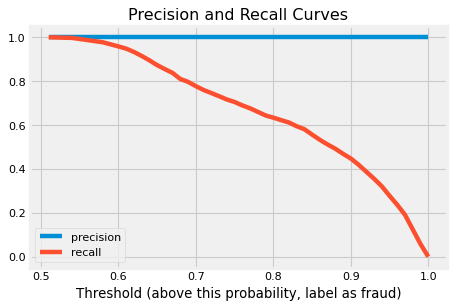

In [123]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(dt_y_train, weighted_rf.predict_proba(dt_X_train)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [124]:
interactive(lambda threshold: dt_confusion_matrix(weighted_rf, threshold), threshold=(0,1.0000,0.0001))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

 <font size="3"> Trying Gradient Boosting and Evaluating Metrics </font>

In [133]:
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [135]:
rmse(rf.predict(dt_X_test), dt_y_test)

0.04403888795504326

In [171]:
gbm = xgb.XGBRegressor( 
                       n_estimators=10000, 
                       max_depth=10,
                       objective="reg:squarederror",  
                       learning_rate=.01, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(dt_X_train, dt_y_train),(dt_X_test,dt_y_test)]
fit_model = gbm.fit( 
                    dt_X_train, dt_y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=30,
                    verbose = True 
                   )
rmse(gbm.predict(dt_X_test, ntree_limit=gbm.best_ntree_limit),dt_y_test)


[0]	validation_0-rmse:0.49512	validation_1-rmse:0.49510
[1]	validation_0-rmse:0.49023	validation_1-rmse:0.49021
[2]	validation_0-rmse:0.48530	validation_1-rmse:0.48532
[3]	validation_0-rmse:0.48039	validation_1-rmse:0.48053
[4]	validation_0-rmse:0.47585	validation_1-rmse:0.47573
[5]	validation_0-rmse:0.47109	validation_1-rmse:0.47108
[6]	validation_0-rmse:0.46633	validation_1-rmse:0.46642
[7]	validation_0-rmse:0.46177	validation_1-rmse:0.46180
[8]	validation_0-rmse:0.45724	validation_1-rmse:0.45727
[9]	validation_0-rmse:0.45263	validation_1-rmse:0.45273
[10]	validation_0-rmse:0.44807	validation_1-rmse:0.44822
[11]	validation_0-rmse:0.44368	validation_1-rmse:0.44382
[12]	validation_0-rmse:0.43930	validation_1-rmse:0.43944
[13]	validation_0-rmse:0.43492	validation_1-rmse:0.43507
[14]	validation_0-rmse:0.43069	validation_1-rmse:0.43074
[15]	validation_0-rmse:0.42645	validation_1-rmse:0.42651
[16]	validation_0-rmse:0.42228	validation_1-rmse:0.42231
[17]	validation_0-rmse:0.41811	validation

0.04017751730541798

In [165]:
model = gbm.best_ntree_limit
model

637

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

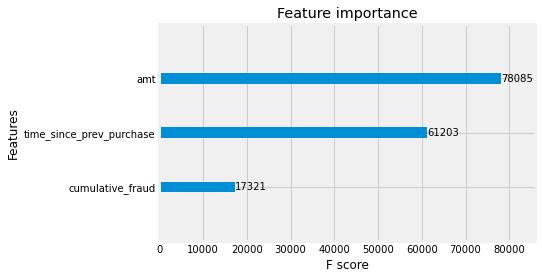

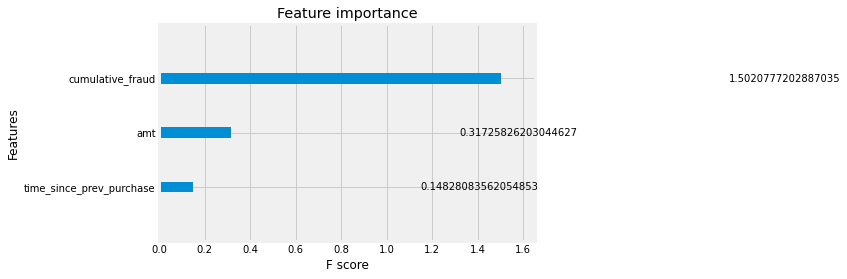

In [148]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

In [149]:
gbm.get_booster().get_score(importance_type='weight')

{'cumulative_fraud': 17321, 'time_since_prev_purchase': 61203, 'amt': 78085}

In [150]:
gbm.get_booster().get_score(importance_type='gain')

{'cumulative_fraud': 1.5020777202887035,
 'time_since_prev_purchase': 0.14828083562054853,
 'amt': 0.31725826203044627}

In [151]:
gbm.get_booster().get_score(importance_type='cover')

{'cumulative_fraud': 18501.74683909705,
 'time_since_prev_purchase': 9632.902194336879,
 'amt': 14406.68552218736}

In [194]:
X = df[['amt',
       'time_since_prev_purchase', 'cumulative_fraud',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel']]

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, dt_y, random_state=42)
rf_1 = RandomForestClassifier(n_estimators=100)
rf_1.fit(X_train, y_train)

RandomForestClassifier()

In [181]:
rf_acc_scores = cross_val_score(rf_1, X_train, y_train, cv=10, scoring='accuracy')
rf_prec_scores = cross_val_score(rf_1, X_train, y_train, cv=10, scoring='precision')
rf_rec_scores = cross_val_score(rf_1, X_train, y_train, cv=10, scoring='recall')
print("Accuracy: " , rf_acc_scores, "\n", "Precision: ", rf_prec_scores, "\n", "Recall: ", rf_rec_scores)

Accuracy:  [0.99920694 0.99899063 0.99908676 0.99906273 0.99872627 0.99877433
 0.99894256 0.99899063 0.99891853 0.99925499] 
 Precision:  [0.93661972 0.953125   0.92857143 0.96124031 0.90151515 0.90839695
 0.92647059 0.96031746 0.91851852 0.97761194] 
 Recall:  [0.825      0.7672956  0.81132075 0.78616352 0.75       0.74375
 0.78125    0.7625     0.775      0.81875   ]


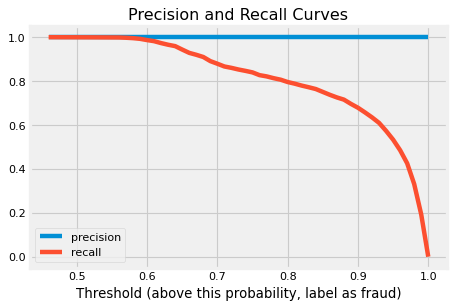

In [182]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_train, rf_1.predict_proba(X_train)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [185]:
def rf_1_confusion_matrix(model, threshold=0.5):
    y_predict = (model.predict_proba(X_train)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_train, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [186]:
interactive(lambda threshold: rf_1_confusion_matrix(rf_1, threshold), threshold=(0,1.0000,0.0001))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

In [187]:
def rf_test_confusion_matrix(model, threshold=0.5):
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [188]:
interactive(lambda threshold: rf_test_confusion_matrix(rf_1, threshold), threshold=(0,1.0000,0.0001))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

In [193]:
493 / (493 + 35)

0.9337121212121212

In [196]:
gbm = xgb.XGBRegressor( 
                       n_estimators=10000, 
                       max_depth=10,
                       objective="reg:squarederror",  
                       learning_rate=.01, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train, y_train),(X_test, y_test)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=30,
                    verbose = True 
                   )

[0]	validation_0-rmse:0.49512	validation_1-rmse:0.49510
[1]	validation_0-rmse:0.49018	validation_1-rmse:0.49016
[2]	validation_0-rmse:0.48526	validation_1-rmse:0.48529
[3]	validation_0-rmse:0.48036	validation_1-rmse:0.48047
[4]	validation_0-rmse:0.47579	validation_1-rmse:0.47568
[5]	validation_0-rmse:0.47098	validation_1-rmse:0.47097
[6]	validation_0-rmse:0.46625	validation_1-rmse:0.46632
[7]	validation_0-rmse:0.46164	validation_1-rmse:0.46167
[8]	validation_0-rmse:0.45710	validation_1-rmse:0.45710
[9]	validation_0-rmse:0.45247	validation_1-rmse:0.45255
[10]	validation_0-rmse:0.44797	validation_1-rmse:0.44804
[11]	validation_0-rmse:0.44354	validation_1-rmse:0.44366
[12]	validation_0-rmse:0.43916	validation_1-rmse:0.43927
[13]	validation_0-rmse:0.43482	validation_1-rmse:0.43489
[14]	validation_0-rmse:0.43053	validation_1-rmse:0.43059
[15]	validation_0-rmse:0.42626	validation_1-rmse:0.42631
[16]	validation_0-rmse:0.42203	validation_1-rmse:0.42206
[17]	validation_0-rmse:0.41785	validation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

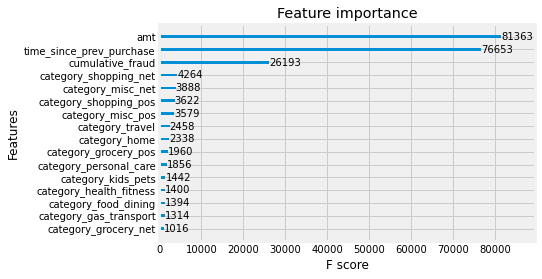

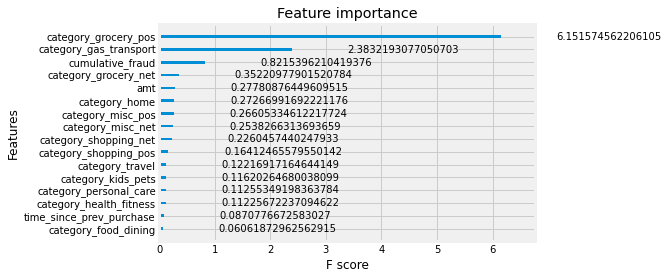

In [197]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')